In [35]:
import torch
import numpy
import matplotlib.pyplot as plt

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
print(torch.__version__)

cpu
2.5.1+cpu


In [37]:
# y = weight * X(features) + bias
weight = 0.7
bias = 0.3

# range
start = 0
end = 1
step = 0.02

# X(features) and y(labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [38]:
# split data
train_split = int(0.8 * len(X)) # take 80% of sample for training
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X), train_split, len(X_train), len(y_train), len(X_test), len(y_test) # print lengths

(50, 40, 40, 40, 10, 10)

In [39]:
# plot data function
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    plt.figure(figsize=(8,5))

    # plot training data
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

    # plot test data
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")

    # are there predictions
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    # show legend
    plt.legend(prop={"size": 14})

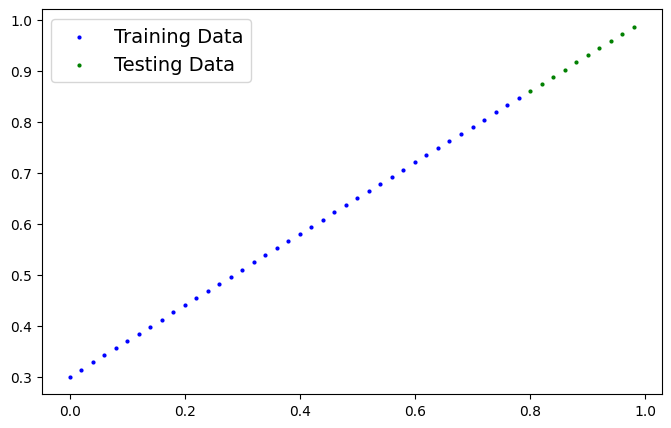

In [40]:
plot_predictions(X_train, y_train, X_test, y_test)

In [41]:
# pytorch linear model by subclassing nn.module
class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # nn.Linear() for creating module parameters
        self.linear_layer = torch.nn.Linear(in_features=1,
                                            out_features=1) # 1 input and 1 output features because in our data, 1 value of our X_train corresponds to 1 value of y_train
    
    def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
        return self.linear_layer(x)


In [42]:
# set manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModel()
model_1, model_1.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [43]:
# check model's current device
# next(model_1.parameters()).device

# set model to use target device
model_1.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [44]:
# setup loss function
loss_fn = torch.nn.L1Loss() # same as MAE

# setup optimizers
optimizer = torch.optim.SGD(params=model_1.parameters(), # parameters we want our optimizers to optimize
                            lr=0.01) # lr = learning rate 


In [45]:
# training loop
torch.manual_seed(42)

epochs = 200

for epoch in range(epochs):
    model_1.train() # model to train

    # 1. forward pass(calculates predictions)
    y_pred = model_1(X_train)

    # 2. calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. optimizer zero grad
    optimizer.zero_grad() # prevent optimizer from accumulating gradients

    # 4. perform backpropagation
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ### testing
    # it is best practice to set the model to evaluation mode when testing
    # model_1.eval() # set model to evaluation mode turn off things like dropout, batch normalization layer etc
    # with torch.inference_mode(): # to not track gradients etc
    #     test_pred = model_1(X_test)
    #     test_loss = loss_fn(test_pred, y_test)

    # print results
    # if epoch%10 == 0:
    #     print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

In [46]:
### Making and evaluating predictions
model_1.eval()

# make predictions on test data(data that our model has not seen yet)
with torch.inference_mode():
    y_preds=model_1(X_test)


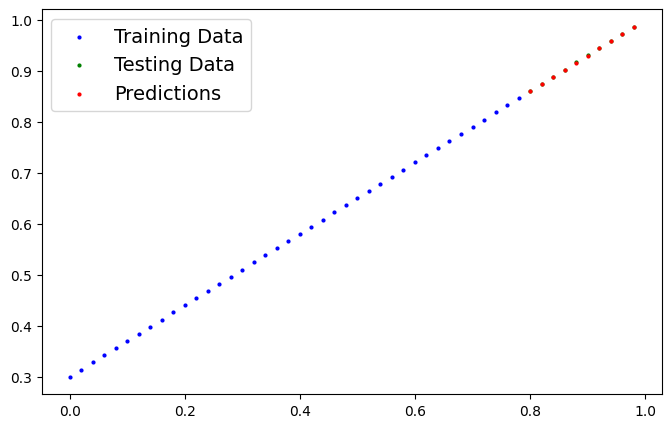

In [47]:
# check out predictions
plot_predictions(X_train, y_train, X_test, y_test, predictions=y_preds)

In [48]:
# saving and loading model  
from pathlib import Path

# 1. create model directory
# PATH = "."
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. create model save path
MODEL_NAME = "model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. save the model dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/model_1.pth


In [49]:
# load pytorch model

# create new instance of linear regression model
loaded_model_1 = LinearRegressionModel()

# load saved model state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# put the loaded model to the device
loaded_model_1.to(device)

/tmp/ipykernel_6445/1284513612.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [50]:
# evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])